<a href="https://colab.research.google.com/github/amimulhasan/Deep-Learning/blob/main/multi_disease_cnn_vit_gru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        (os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import numpy as np
from PIL import Image
import os

# ------------------------
# SETTINGS
# ------------------------
dataset_dir = "/kaggle/input/alz-b-1100/alzheimer_new_11/alzheimer_new"  # Update path as needed
img_size = (128,128)

X = []
y = []

# --- Get all class folders (e.g., 4 classes) ---
class_names = sorted([d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))])
print("✅ Classes found:", class_names)

if len(class_names) != 8:
    raise ValueError(f"Expected exactly 4 classes, found {len(class_names)}: {class_names}")

# --- Walk through each class and collect images ---
for idx, class_name in enumerate(class_names):
    class_path = os.path.join(dataset_dir, class_name)
    print(f"🔍 Processing class '{class_name}' ({idx})")

    for root, _, files in os.walk(class_path):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path).convert('RGB')
                img = img.resize(img_size)
                img_array = np.array(img) / 255.0  # Normalize
                X.append(img_array)
                y.append(idx)
            except Exception as e:
                print(f"⚠️ Failed to process {file_path}: {e}")

# ------------------------
# CONVERT TO NUMPY ARRAYS
# ------------------------
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.int32)

print(f"\n✅ Dataset loaded successfully:")
print(f"   X shape = {X.shape}")
print(f"   y shape = {y.shape}")
print(f"   Class mapping = {dict(enumerate(class_names))}")

# ------------------------
# SAVE AS .NPY FILES
# ------------------------
np.save("X.npy", X)
np.save("y.npy", y)
print("✅ Saved X.npy and y.npy to current working directory.")


✅ Classes found: ['MildDemented', 'Moderate Dementia', 'NonDemented', 'Very mild Dementia', 'glioma', 'meningioma', 'notumor', 'pituitary']
🔍 Processing class 'MildDemented' (0)
🔍 Processing class 'Moderate Dementia' (1)
🔍 Processing class 'NonDemented' (2)
🔍 Processing class 'Very mild Dementia' (3)
🔍 Processing class 'meningioma' (5)
🔍 Processing class 'notumor' (6)
🔍 Processing class 'pituitary' (7)

✅ Dataset loaded successfully:
   X shape = (8800, 128, 128, 3)
   y shape = (8800,)
   Class mapping = {0: 'MildDemented', 1: 'Moderate Dementia', 2: 'NonDemented', 3: 'Very mild Dementia', 4: 'glioma', 5: 'meningioma', 6: 'notumor', 7: 'pituitary'}
✅ Saved X.npy and y.npy to current working directory.


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image

2025-11-14 11:53:04.655529: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763121184.843717      39 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763121184.897130      39 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
X = np.load("/kaggle/working/X.npy")
y = np.load("/kaggle/working/y.npy")

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming X and y are already loaded from your .npy files
# X = np.load("/path/to/X.npy")
# y = np.load("/path/to/y.npy")

# Define the class labels (0 - Glioma, 1 - Meningioma, 2 - Pituitary, 3 - No Tumor)
classes = ['Glioma', 'Meningioma', 'Pituitary', 'No Tumor']

# Initialize a dictionary to hold the train-test data for each class
class_data = {}

# Split the data for each class
for cls in range(4):  # Assuming 0 -> Glioma, 1 -> Meningioma, 2 -> Pituitary, 3 -> No Tumor
    # Get the indices for each class
    class_indices = np.where(y == cls)[0]
    class_X = X[class_indices]  # Features for this class
    class_y = y[class_indices]  # Labels for this class

    # Split into train and test for each class
    X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
        class_X, class_y, test_size=0.2, random_state=42, stratify=class_y)

    # Store the train-test split for this class
    class_data[classes[cls]] = {
        'X_train': X_train_class,
        'y_train': y_train_class,
        'X_test': X_test_class,
        'y_test': y_test_class
    }

# Example: Print the shape of training and test sets for Glioma
print("Glioma Train Features:", class_data['Glioma']['X_train'].shape)
print("Glioma Test Features:", class_data['Glioma']['X_test'].shape)
print("Meningioma Train Features:", class_data['Meningioma']['X_train'].shape)
print("Meningioma Test Features:", class_data['Meningioma']['X_test'].shape)
print("Pituitary Train Features:", class_data['Pituitary']['X_train'].shape)
print("Pituitary Test Features:", class_data['Pituitary']['X_test'].shape)
print("No Tumor Train Features:", class_data['No Tumor']['X_train'].shape)
print("No Tumor Test Features:", class_data['No Tumor']['X_test'].shape)


Glioma Train Features: (880, 128, 128, 3)
Glioma Test Features: (220, 128, 128, 3)
Meningioma Train Features: (880, 128, 128, 3)
Meningioma Test Features: (220, 128, 128, 3)
Pituitary Train Features: (880, 128, 128, 3)
Pituitary Test Features: (220, 128, 128, 3)
No Tumor Train Features: (880, 128, 128, 3)
No Tumor Test Features: (220, 128, 128, 3)


In [ ]:
print("Dataset shapes:", X.shape, y.shape)

Dataset shapes: (8800, 128, 128, 3) (8800,)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}")

Train: (7040, 128, 128, 3), Val: (1760, 128, 128, 3)


In [ ]:
from tensorflow.keras import models, layers

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
# -----------------------
# Hyperparameters
# -----------------------
input_shape = (128, 128, 3)
patch_size = 16
num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
projection_dim = 64
transformer_layers = 4
num_heads = 8
num_classes = 8

# -----------------------
# Patches layer
# -----------------------
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

# -----------------------
# Patch Encoder layer
# -----------------------
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patches):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patches) + self.position_embedding(positions)
        return encoded

# -----------------------
# Build the combined model
# -----------------------
def build_hybrid_model():
    inputs = layers.Input(shape=input_shape)

    # ---------------------
    # DCNN Branch
    # ---------------------
    x_cnn = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x_cnn = layers.MaxPooling2D((2,2))(x_cnn)
    x_cnn = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x_cnn)
    x_cnn = layers.MaxPooling2D((2,2))(x_cnn)
    x_cnn = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x_cnn)
    x_cnn = layers.MaxPooling2D((2,2))(x_cnn)
    x_cnn = layers.Flatten()(x_cnn)

    # ---------------------
    # ViT + GRU Branch
    # ---------------------
    x_vit = layers.Rescaling(1./255)(inputs)
    patches = Patches(patch_size)(x_vit)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.2
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        encoded_patches = layers.Add()([x3, x2])

    x_vit = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    x_vit = layers.Dropout(0.002)(x_vit)
    x_vit = layers.Flatten()(x_vit)
    x_vit = layers.Reshape((-1, x_vit.shape[-1]))(x_vit)
    x_vit = layers.GRU(256)(x_vit)

    # ---------------------
    # Concatenate DCNN and ViT+GRU
    # ---------------------
    x = layers.concatenate([x_cnn, x_vit])
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.003)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Build model
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# -----------------------
# Compile and summary
# -----------------------
model = build_hybrid_model()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


I0000 00:00:1763121203.195635      39 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches (Patches)   │ (None, None, 768) │          0 │ rescaling[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder       │ (None, 64, 64)    │     53,312 │ patches[0][0]     │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 64, 64)    │        128 │ patch_encoder[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 64, 64)    │    132,672 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ patch_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 64)    │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 64, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 64)    │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 64, 64)    │    132,672 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 64, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 64)    │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 64, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 64)    │        128 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 64, 64)    │    132,672 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 64, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ add_3[0][0]     

 Total params: 12,478,728 (47.60 MB)

 Trainable params: 12,478,728 (47.60 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# from tensorflow.keras.optimizers import SGD

# # Build your model
# model = build_hybrid_model()

# # Compile with Adamax optimizer
# adamw = SGD(learning_rate=0.001)   # you can tune learning_rate
# model.compile(optimizer=adamw,
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# model.summary()


In [ ]:



import time

# Record start time
start_time = time.time()

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=64)

# Record stop time
end_time = time.time()

# Calculate total time taken
training_time = end_time - start_time

# Print the time taken
print(f"Training Time: {training_time} seconds")







Epoch 1/100


I0000 00:00:1763121223.570444      95 cuda_dnn.cc:529] Loaded cuDNN version 90300


110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.9823 - loss: 0.0564 - val_accuracy: 0.9801 - val_loss: 0.0603
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.9938 - loss: 0.0205 - val_accuracy: 0.9818 - val_loss: 0.0629
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.9980 - loss: 0.0064 - val_accuracy: 0.9909 - val_loss: 0.0398
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.9979 - loss: 0.0058 - val_accuracy: 0.9852 - val_loss: 0.0673
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.9929 - loss: 0.0246 - val_accuracy: 0.9881 - val_loss: 0.0340
Epoch 7/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.9983 - loss: 0.0059 - val_accuracy: 0.9943 - val_loss: 0.0217
Epoch 8/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.9928 - loss: 0.0243 - val_accuracy: 0.9955 - val_loss: 0.0191
Epoch 9/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 1.0000 - loss: 2.5897e-04 - val_accu

In [ ]:
# train_loss = history.history['loss'][-1]
# val_loss = history.history['val_loss'][-1]
# train_acc = history.history['accuracy'][-1] * 100
# val_acc = history.history['val_accuracy'][-1] * 100

# # -----------------------
# # Predictions & evaluation
# # -----------------------
# y_val_pred_prob = model.predict(X_val)
# y_val_pred = np.argmax(y_val_pred_prob, axis=1)

# precision = precision_score(y_val, y_val_pred, average='weighted') * 100
# recall = recall_score(y_val, y_val_pred, average='weighted') * 100
# f1 = f1_score(y_val, y_val_pred, average='weighted') * 100

# # -----------------------
# # Print results
# # -----------------------
# print("Precision (%):", precision)
# print("Recall (%):", recall)
# print("F1-score (%):", f1)
# print("Training Loss:", train_loss)
# print("Validation Loss:", val_loss)
# print("Training Accuracy (%):", train_acc)
# print("Validation Accuracy (%):", val_acc)
# print("Training Time (s):", training_time)

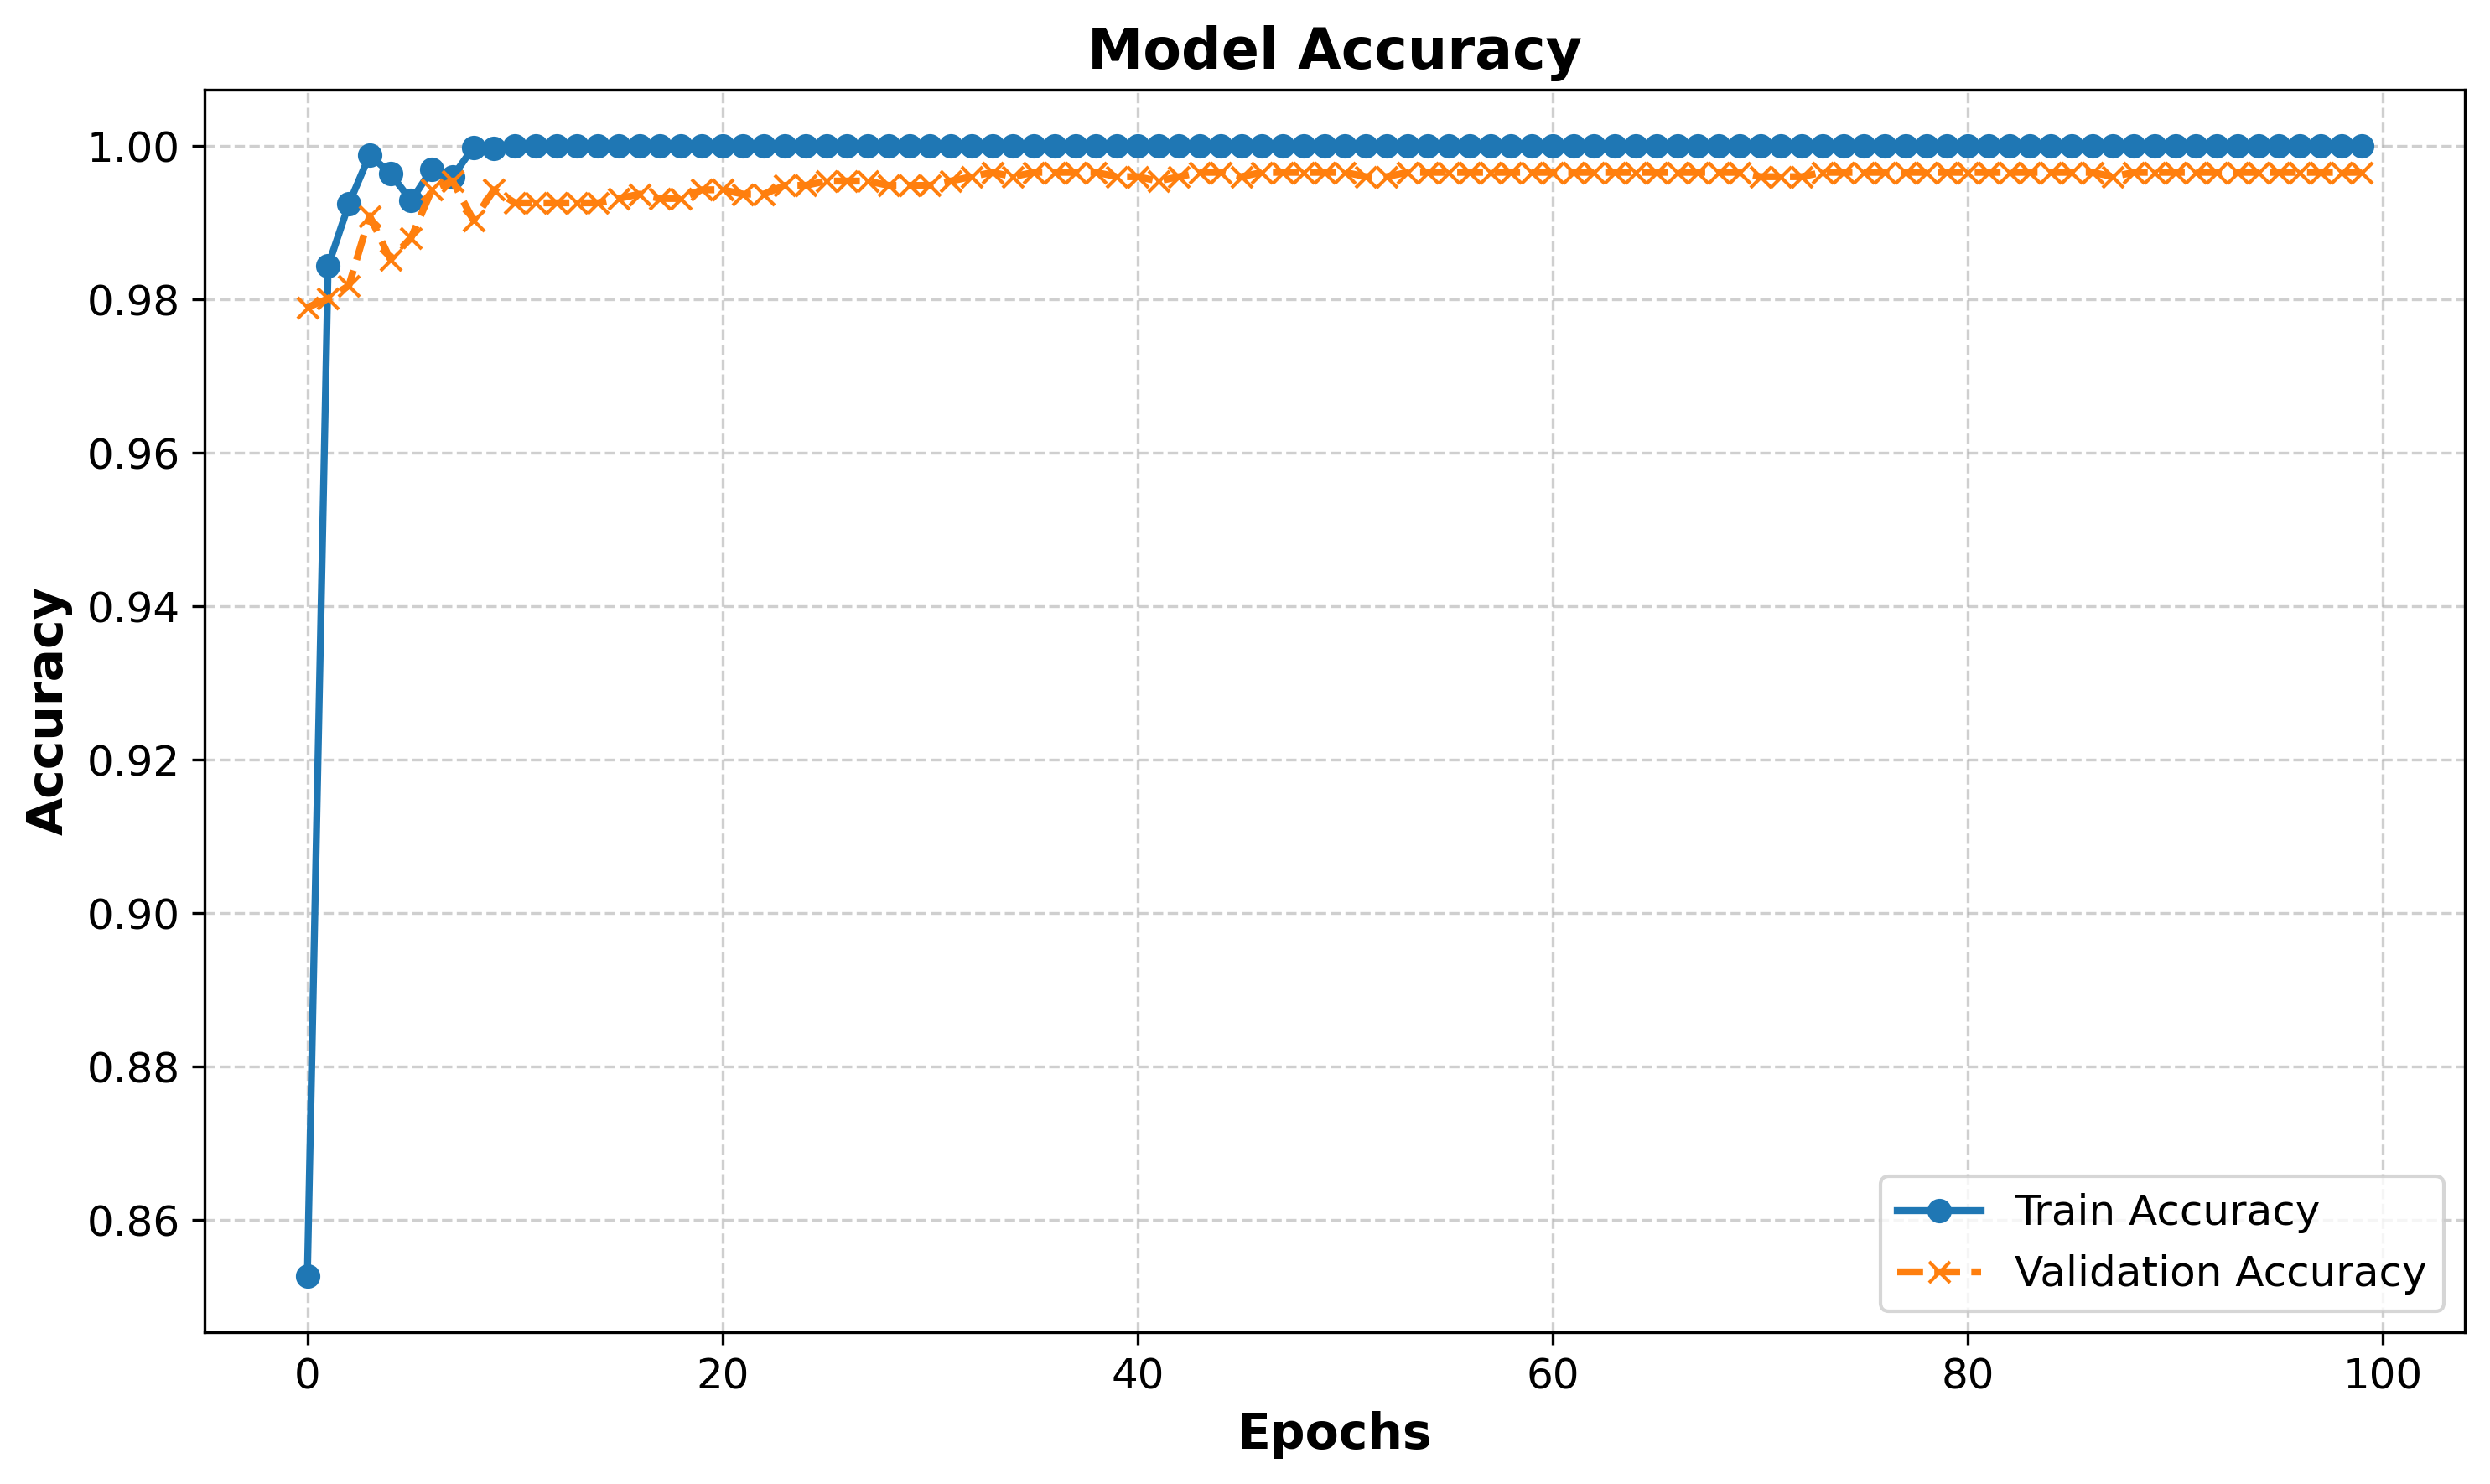

In [ ]:
import matplotlib.pyplot as plt

# ------------------------
# Accuracy Plot (HD)
# ------------------------
plt.figure(figsize=(10, 6), dpi=300)  # HD figure
plt.plot(history.history['accuracy'], marker='o', markersize=6, linewidth=2, label='Train Accuracy')
plt.plot(history.history['val_accuracy'], marker='x', markersize=6, linewidth=2, linestyle='--', label='Validation Accuracy')

plt.title('Model Accuracy', fontsize=16, fontweight='bold')
plt.xlabel('Epochs', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12, loc='lower right')
plt.tight_layout()
plt.savefig('Accuracy_curve_HD.png', dpi=600)  # Ultra HD save
plt.show()


In [ ]:
# import matplotlib.pyplot as plt

# plt.plot(history.history['accuracy'], label='train acc')
# plt.plot(history.history['val_accuracy'], label='val acc')
# plt.legend()
# plt.title('Model Accuracy')
# plt.savefig('Accuray_curve.png', dpi=300)

# plt.show()

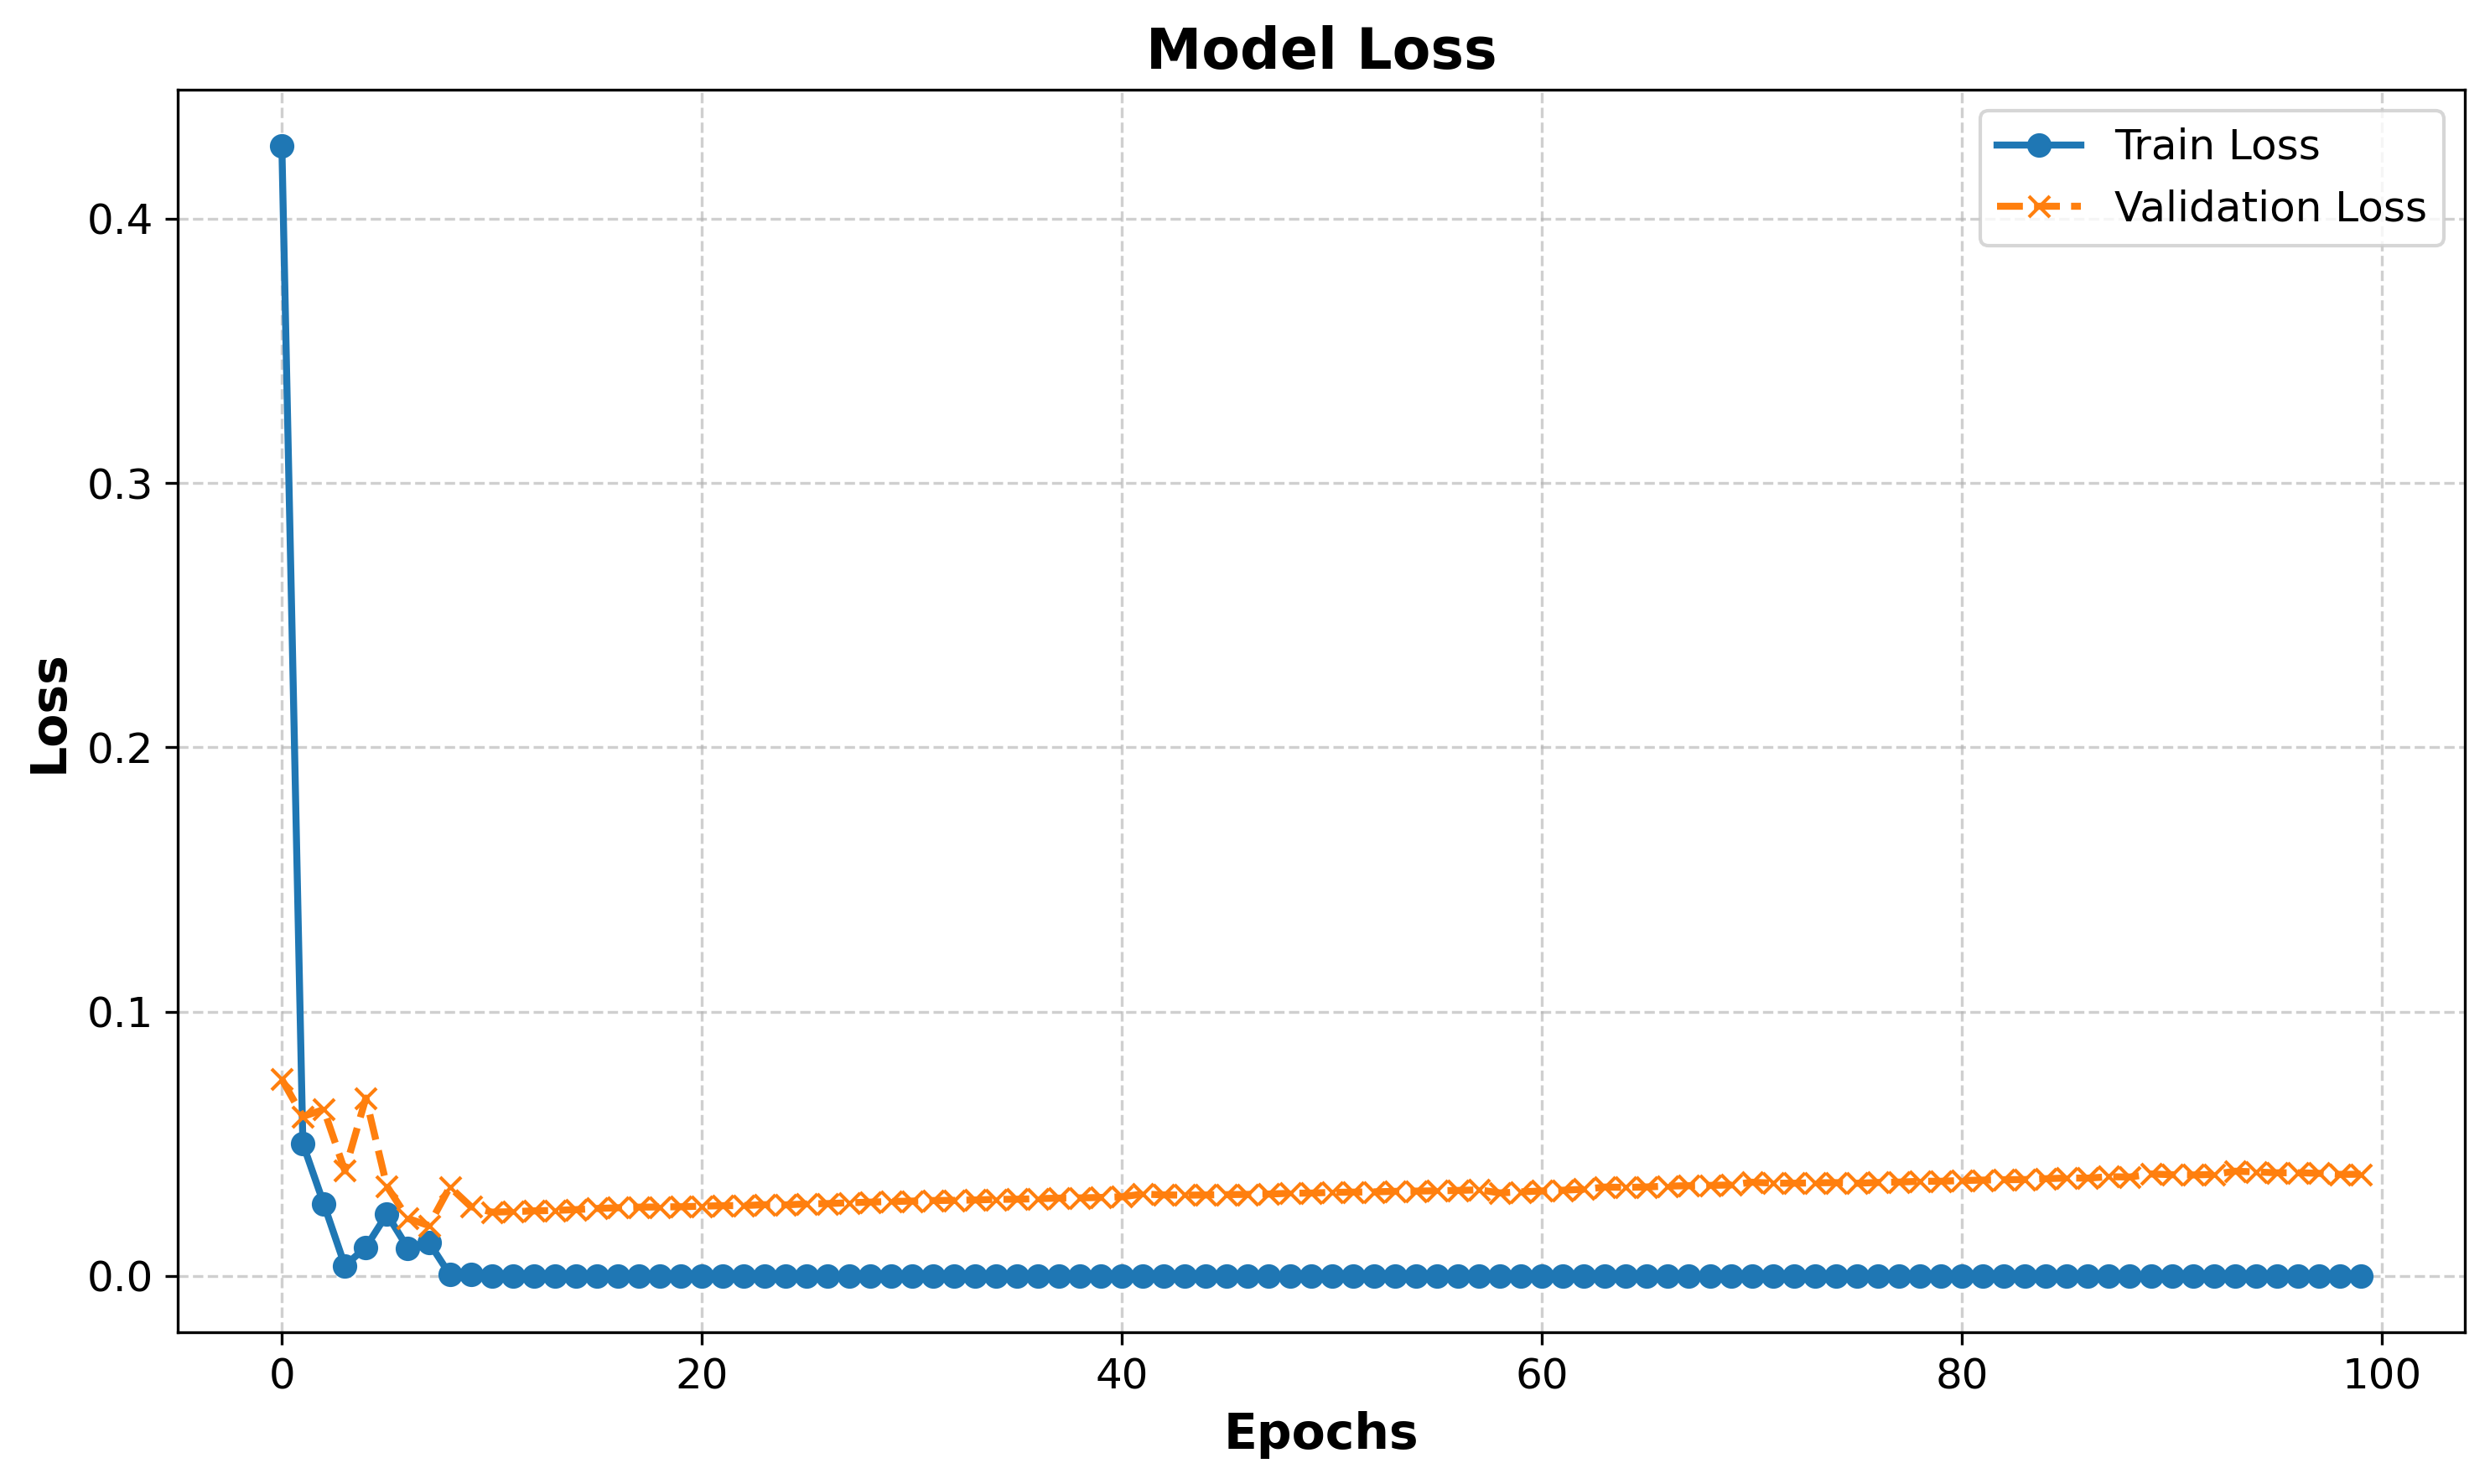

In [ ]:
import matplotlib.pyplot as plt

# ------------------------
# Loss Plot (HD)
# ------------------------
plt.figure(figsize=(10, 6), dpi=300)  # HD figure
plt.plot(history.history['loss'], marker='o', markersize=6, linewidth=2, label='Train Loss')
plt.plot(history.history['val_loss'], marker='x', markersize=6, linewidth=2, linestyle='--', label='Validation Loss')

plt.title('Model Loss', fontsize=16, fontweight='bold')
plt.xlabel('Epochs', fontsize=14, fontweight='bold')
plt.ylabel('Loss', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12, loc='upper right')
plt.tight_layout()
plt.savefig('Loss_curve_HD.png', dpi=600)  # Ultra HD save
plt.show()


In [ ]:
# plt.plot(history.history['loss'], label='train loss')
# plt.plot(history.history['val_loss'], label='val loss')
# plt.legend()
# plt.title('Model Loss')
# plt.savefig('Loss23_curve.png', dpi=300)

# plt.show()

In [ ]:
# cmap='viridis'


Evaluation on validation set:
Validation Loss: 0.0385, Validation Accuracy: 0.9966
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


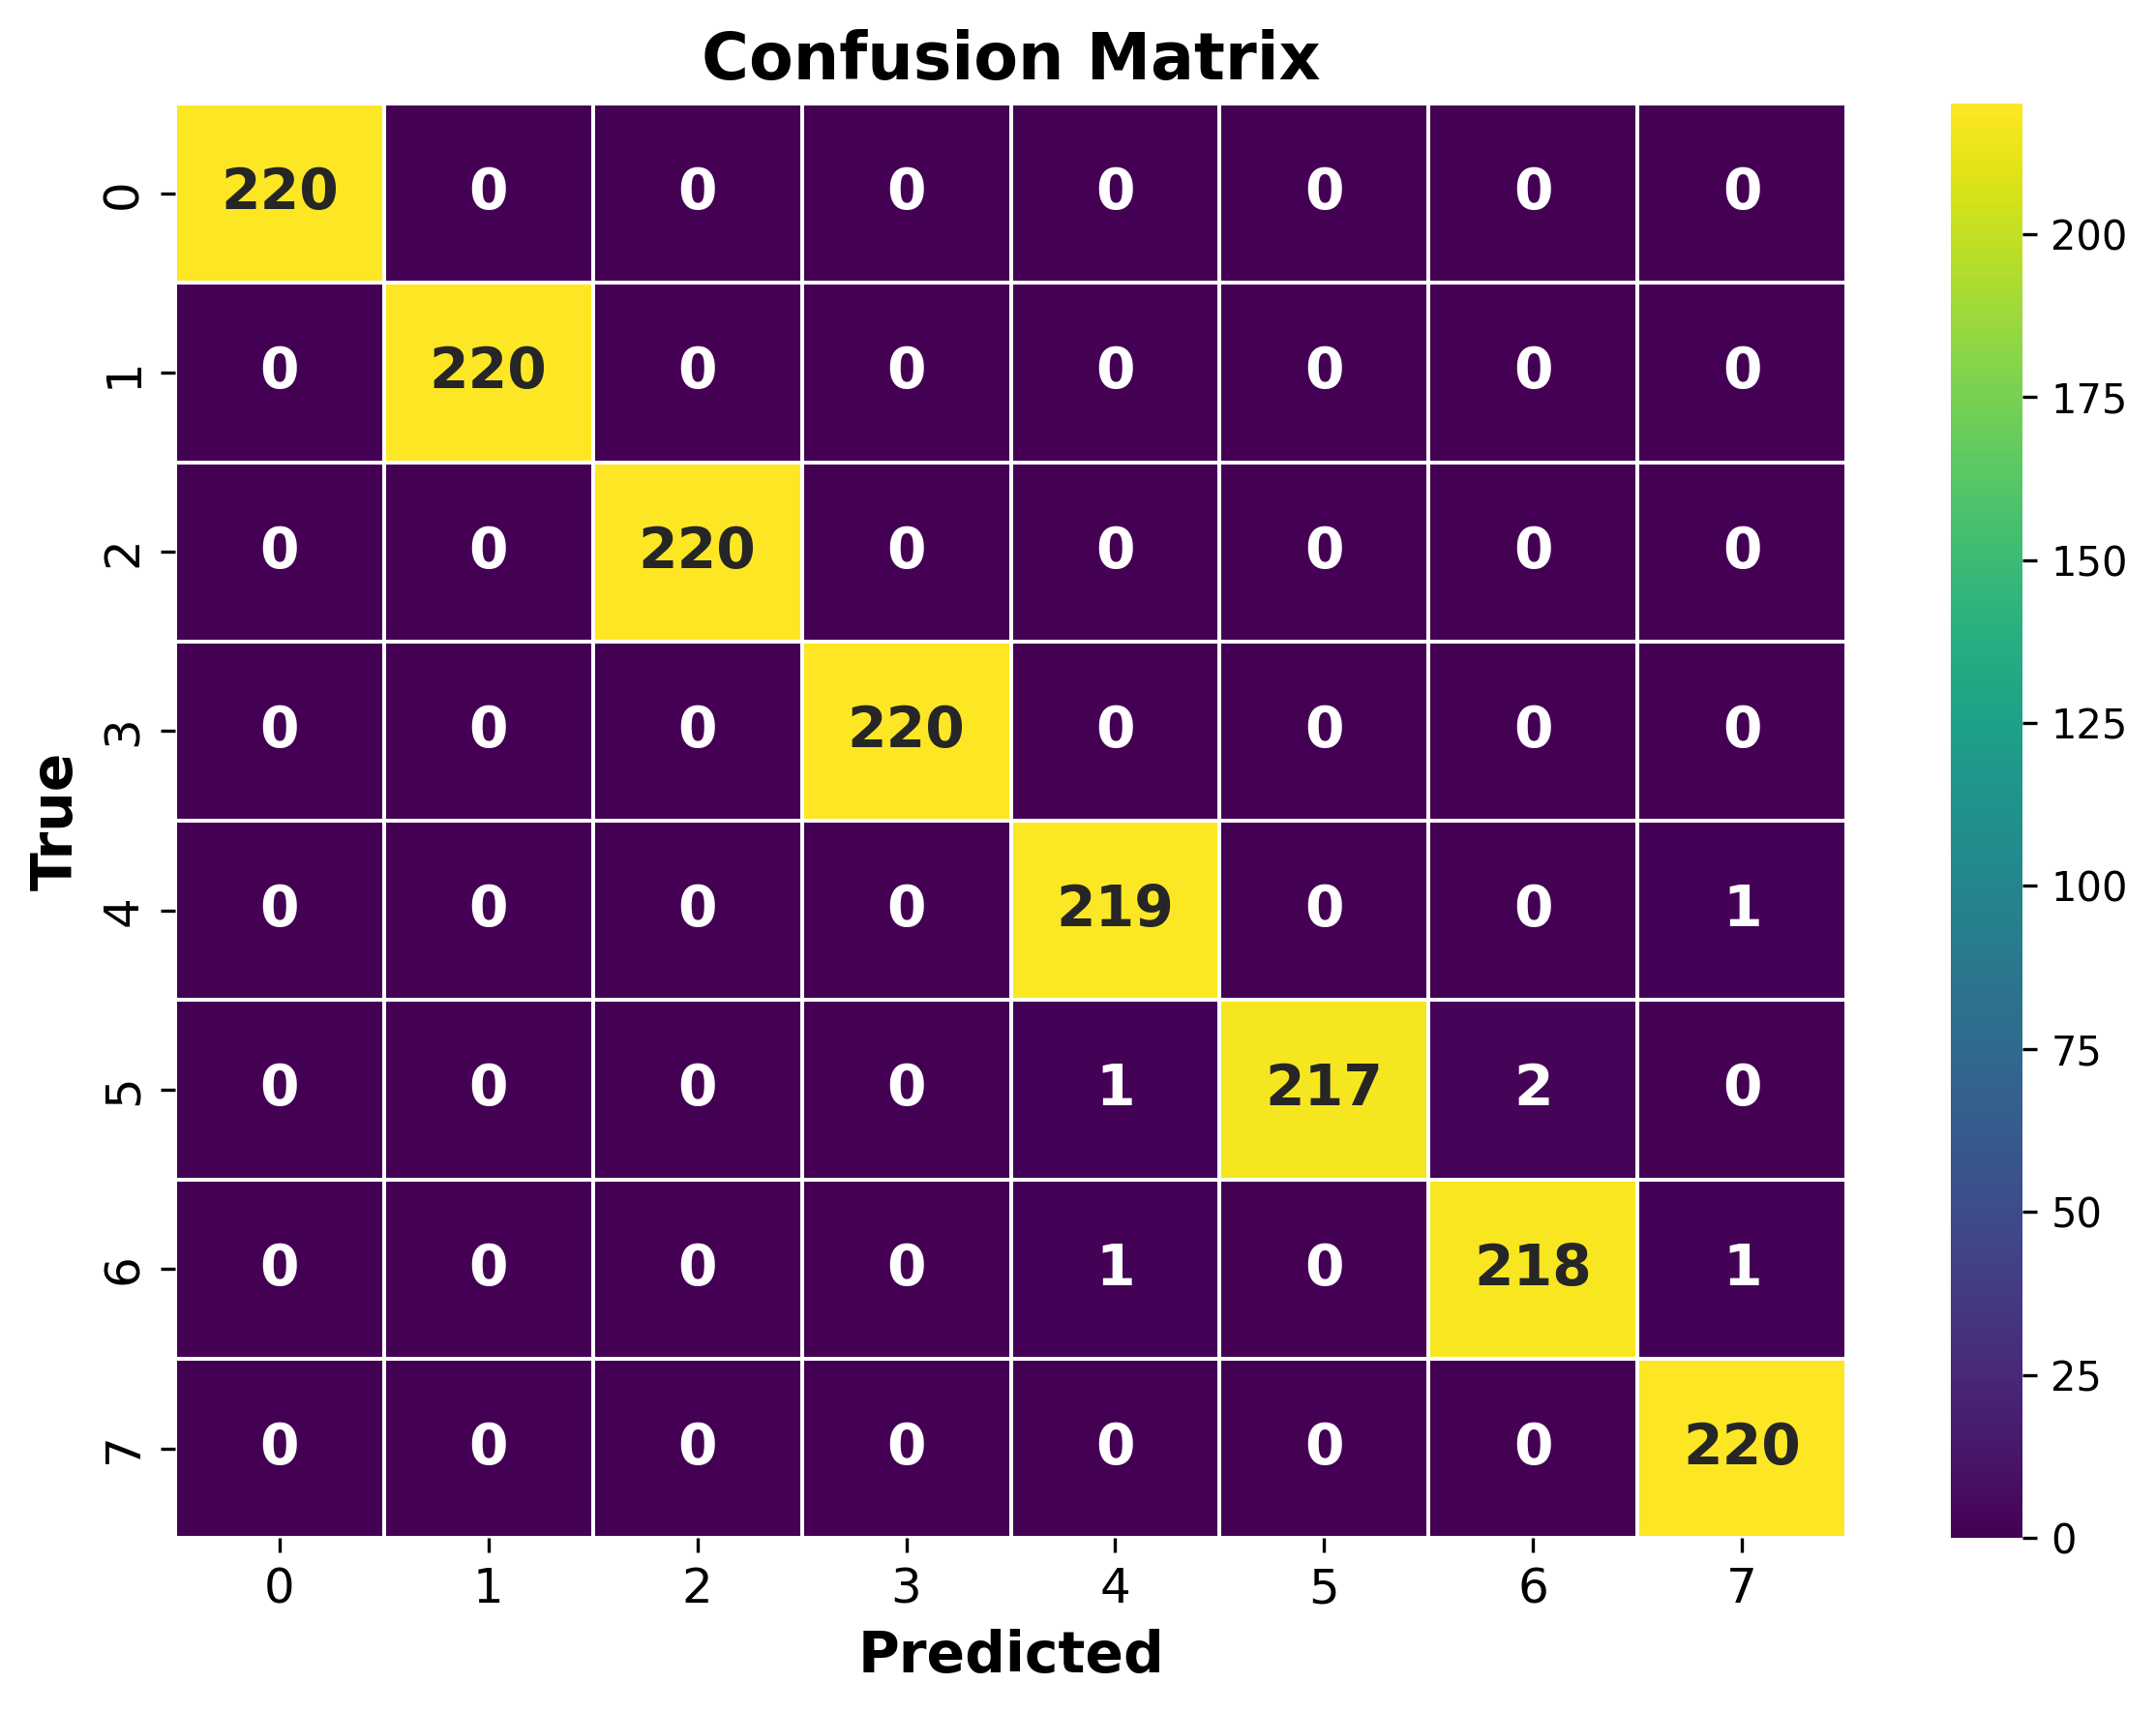


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       220
           1     1.0000    1.0000    1.0000       220
           2     1.0000    1.0000    1.0000       220
           3     1.0000    1.0000    1.0000       220
           4     0.9910    0.9955    0.9932       220
           5     1.0000    0.9864    0.9931       220
           6     0.9909    0.9909    0.9909       220
           7     0.9910    1.0000    0.9955       220

    accuracy                         0.9966      1760
   macro avg     0.9966    0.9966    0.9966      1760
weighted avg     0.9966    0.9966    0.9966      1760



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ------------------------
# Model evaluation on the validation set
# ------------------------
print("\nEvaluation on validation set:")
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

# ------------------------
# Make predictions
# ------------------------
y_pred_probs = model.predict(X_val)  # Predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Class predictions

# ------------------------
# Confusion Matrix (Improved Color)
# ------------------------
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(8, 6), dpi=300)  # HD figure
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='viridis',  # Changed color palette
    xticklabels=np.unique(y_val),
    yticklabels=np.unique(y_val),
    cbar=True,
    annot_kws={"size":14, "weight":"bold"},
    linewidths=0.5,  # Optional: adds grid lines
    linecolor='white'
)
plt.xlabel("Predicted", fontsize=14, weight='bold')
plt.ylabel("True", fontsize=14, weight='bold')
plt.title("Confusion Matrix", fontsize=16, weight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('model_confusion_matrix_HD.png', dpi=600)  # Ultra HD save
plt.show()

# ------------------------
# Classification Report
# ------------------------
print("\nClassification Report:")
print(classification_report(y_val, y_pred, digits=4))


In [ ]:
# from sklearn.metrics import confusion_matrix, classification_report
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# # ------------------------
# # Model evaluation on the validation set
# # ------------------------
# print("\nEvaluation on validation set:")
# val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
# print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

# # ------------------------
# # Make predictions
# # ------------------------
# y_pred_probs = model.predict(X_val)  # Predicted probabilities
# y_pred = np.argmax(y_pred_probs, axis=1)  # Class predictions

# # ------------------------
# # Confusion Matrix (HD)
# # ------------------------
# cm = confusion_matrix(y_val, y_pred)
# plt.figure(figsize=(8, 6), dpi=300)  # HD figure
# sns.heatmap(
#     cm, annot=True, fmt='d', cmap='Blues',
#     xticklabels=np.unique(y_val), yticklabels=np.unique(y_val),
#     cbar=True, annot_kws={"size":14, "weight":"bold"}
# )
# plt.xlabel("Predicted", fontsize=14, weight='bold')
# plt.ylabel("True", fontsize=14, weight='bold')
# plt.title("Confusion Matrix", fontsize=16, weight='bold')
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.tight_layout()
# plt.savefig('model_confusion_matrix_HD.png', dpi=600)  # Ultra HD save
# plt.show()

# # ------------------------
# # Classification Report
# # ------------------------
# print("\nClassification Report:")
# print(classification_report(y_val, y_pred, digits=4))


In [ ]:
# # Model evaluation on the validation set
# print("\nEvaluation on validation set:")
# model.evaluate(X_val, y_val)  # Evaluate the model on the validation set

# # Make predictions
# y_pred_probs = model.predict(X_val)  # Get the predicted probabilities
# y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class predictions

# # Confusion Matrix
# cm = confusion_matrix(y_val, y_pred)
# plt.figure(figsize=(6,6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.xlabel("Predicted")
# plt.ylabel("True")
# plt.title("Confusion Matrix")
# plt.savefig('model_confusion_matrix_curve.png', dpi=300)

# plt.show()

# # Classification Report
# print("\nClassification Report:")
# print(classification_report(y_val, y_pred))


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


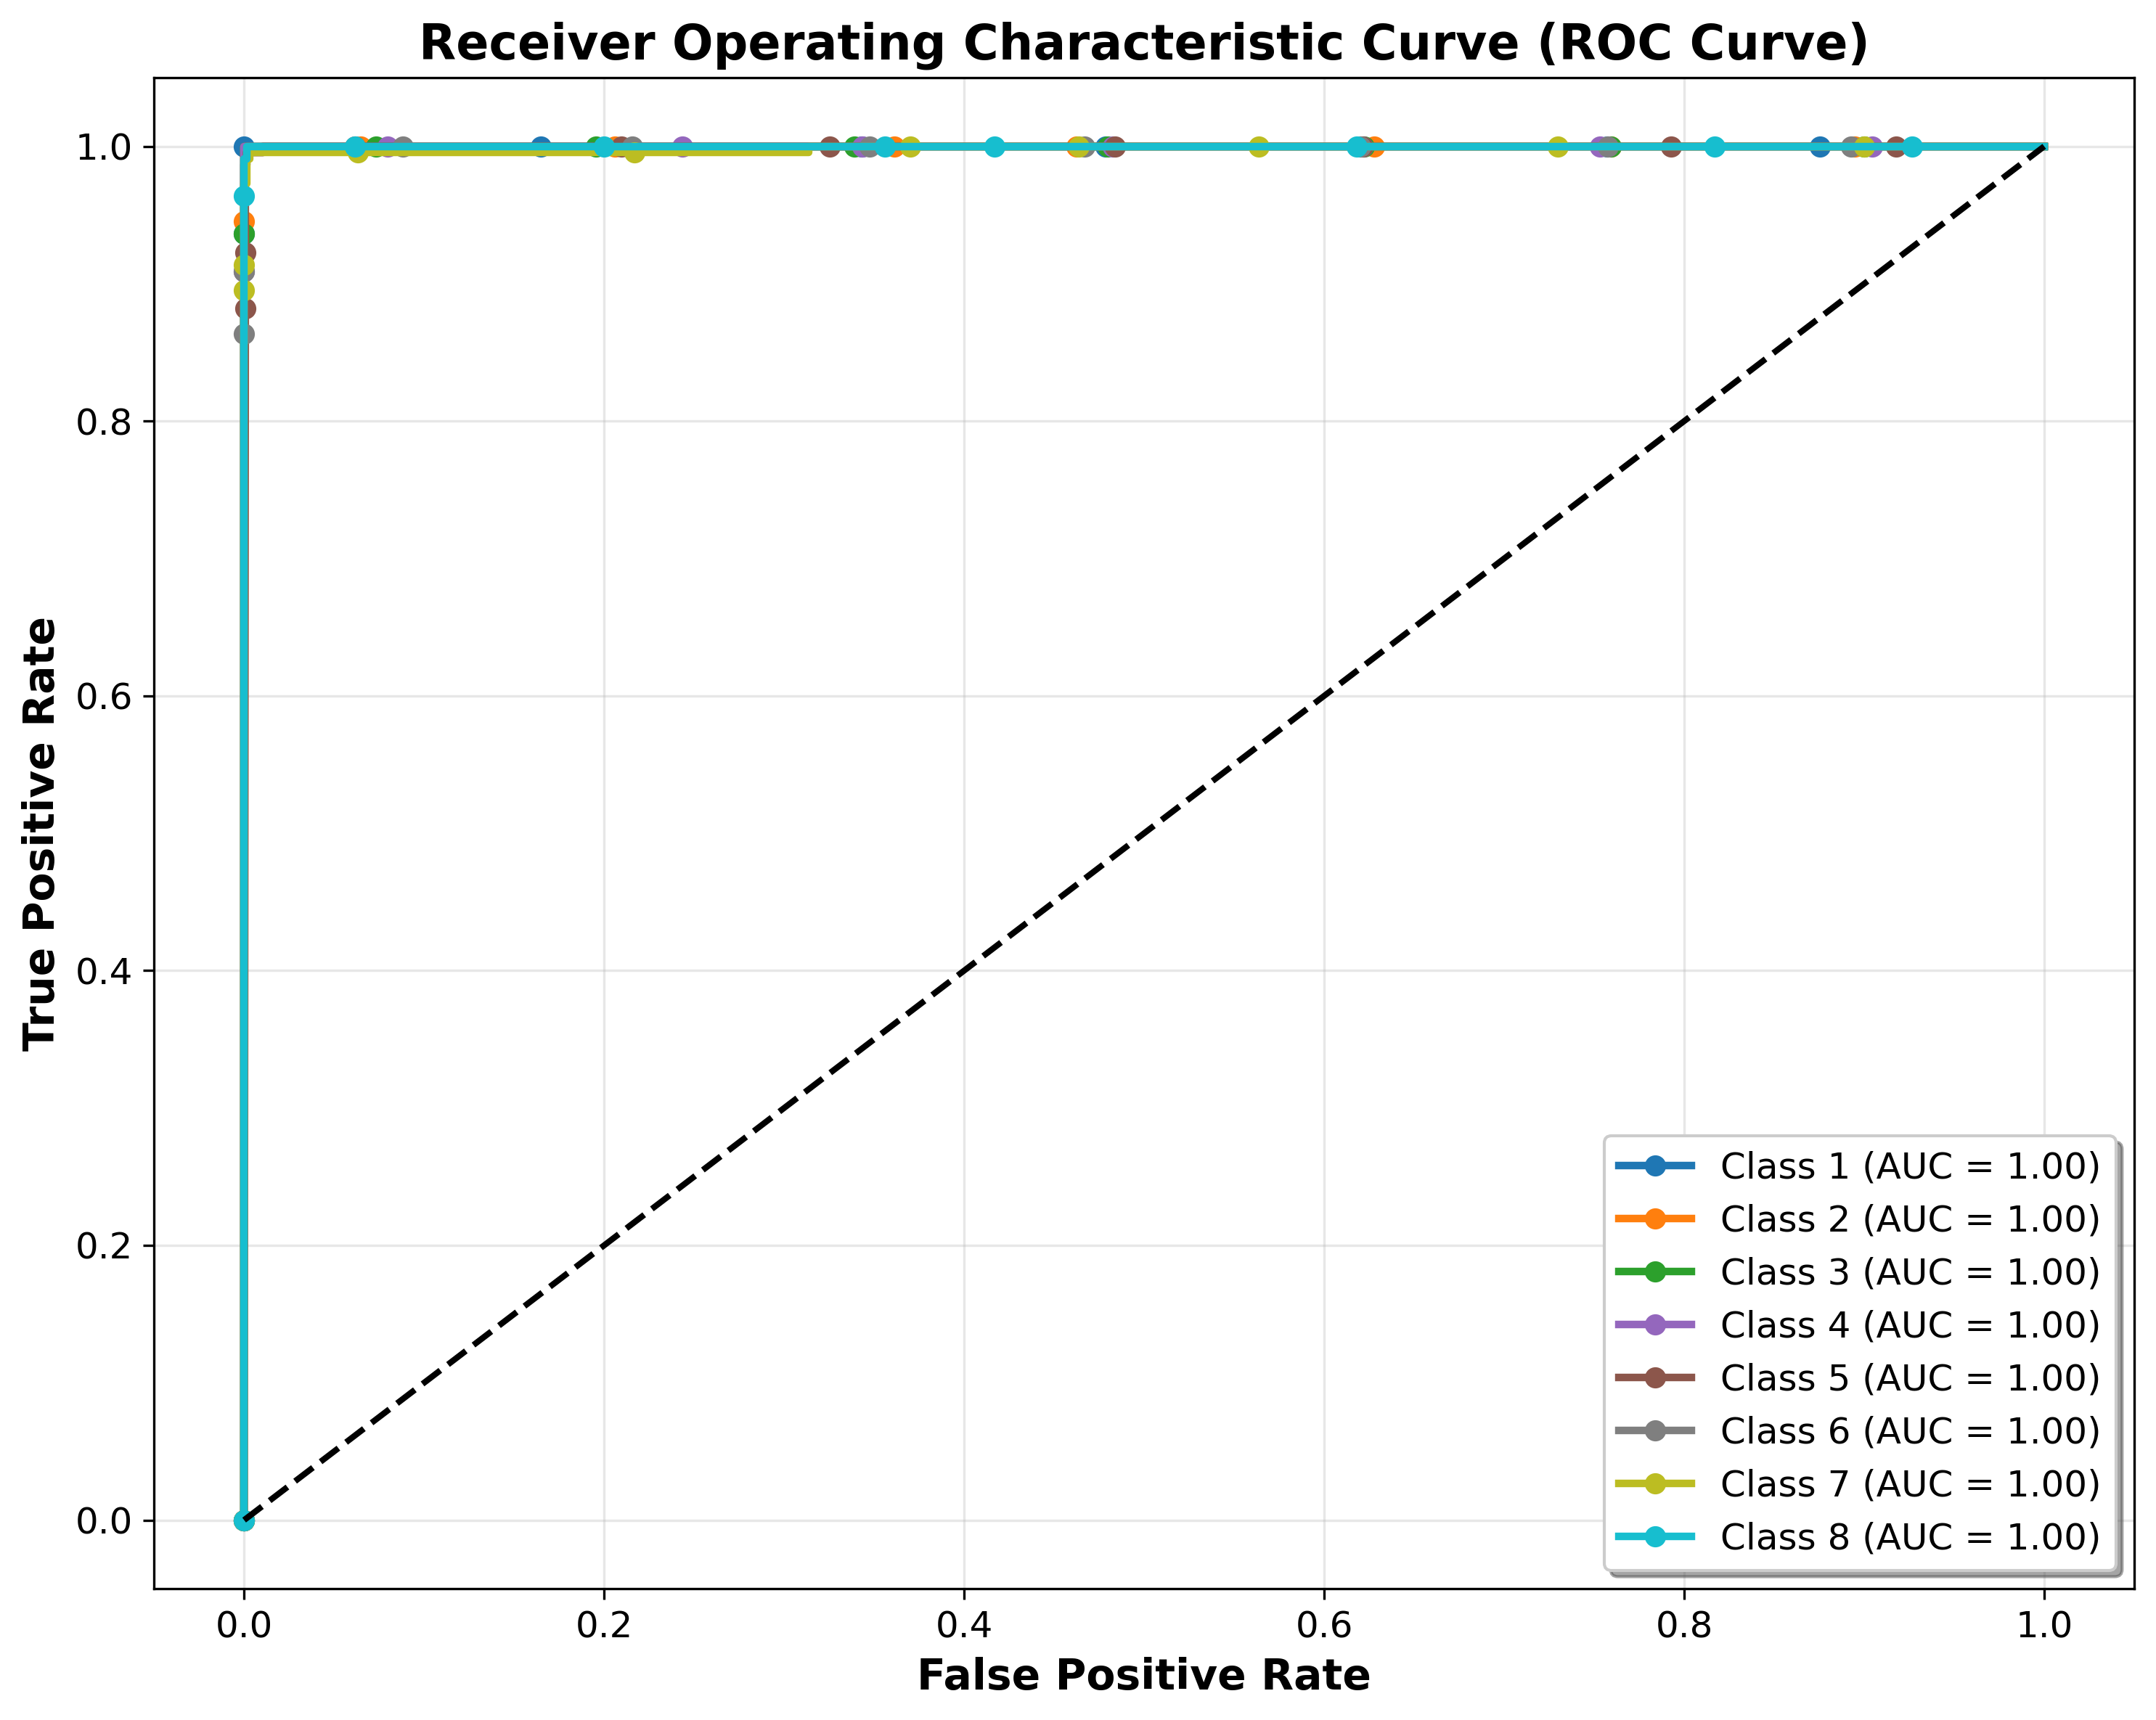

Class 1 AUC: 1.00
Class 2 AUC: 1.00
Class 3 AUC: 1.00
Class 4 AUC: 1.00
Class 5 AUC: 1.00
Class 6 AUC: 1.00
Class 7 AUC: 1.00
Class 8 AUC: 1.00


In [ ]:
# ------------------------
# Predict the probabilities
# ------------------------
y_prob = model.predict(X_val)  # Predicted probabilities for each class using the validation data

# ------------------------
# One-hot encode the true labels for multiclass
# ------------------------
from sklearn.preprocessing import label_binarize
y_val_bin = label_binarize(y_val, classes=np.arange(num_classes))  # auto handles number of classes

# ------------------------
# Calculate ROC and AUC for each class
# ------------------------
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, roc_auc = dict(), dict(), dict()

# Compute ROC curve and AUC for each class
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_prob[:, i])
    roc_auc[i] = roc_auc_score(y_val_bin[:, i], y_prob[:, i])

# ------------------------
# Plot ROC Curves (HD Quality)
# ------------------------
plt.figure(figsize=(10, 8), dpi=300)  # High resolution
colors = plt.cm.tab10(np.linspace(0, 1, num_classes))  # Nice distinct colors

for i, color in zip(range(num_classes), colors):
    plt.plot(
        fpr[i], tpr[i], color=color, lw=2.5, marker='o', markevery=0.1,
        label=f'Class {i+1} (AUC = {roc_auc[i]:.2f})'
    )

plt.plot([0, 1], [0, 1], color='black', linestyle='--', lw=2)

plt.xlabel('False Positive Rate', fontsize=14, weight='bold')
plt.ylabel('True Positive Rate', fontsize=14, weight='bold')
plt.title('Receiver Operating Characteristic Curve (ROC Curve)', fontsize=16, weight='bold')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='lower right', fontsize=12, frameon=True, shadow=True, fancybox=True)

plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('ROC_curve_HD.png', dpi=600)  # Ultra HD figure
plt.show()

# ------------------------
# Print AUC scores for each class
# ------------------------
for i in range(num_classes):
    print(f"Class {i+1} AUC: {roc_auc[i]:.2f}")


In [ ]:

# # ------------------------
# # Predict the probabilities
# # ------------------------
# y_prob = model.predict(X_val)  # Predicted probabilities for each class using the validation data

# # ------------------------
# # One-hot encode the true labels for multiclass
# # ------------------------
# from sklearn.preprocessing import label_binarize
# y_val_bin = label_binarize(y_val, classes=[0, 1, 2, 3])  # One-hot encoding for multiclass

# # ------------------------
# # Calculate ROC and AUC for each class
# # ------------------------
# from sklearn.metrics import roc_curve, roc_auc_score

# fpr, tpr, roc_auc = dict(), dict(), dict()
# num_classes = len(np.unique(y_val))  # Adjust to the number of classes

# # Compute ROC curve and AUC for each class
# for i in range(num_classes):
#     fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_prob[:, i])
#     roc_auc[i] = roc_auc_score(y_val_bin[:, i], y_prob[:, i])

# # ------------------------
# # Plot ROC Curves for each class
# # ------------------------
# plt.figure(figsize=(8, 6))
# for i in range(num_classes):
#     plt.plot(fpr[i], tpr[i], label=f'Class {i+1} (AUC = {roc_auc[i]:0.2f})')

# plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic Curve (ROC Curve)')
# plt.legend(loc='lower right')
# plt.savefig('ROC_curve.png', dpi=300)
# plt.show()

# # ------------------------
# # Print AUC scores for each class
# # ------------------------
# for i in range(num_classes):
#     print(f"Class {i+1} AUC: {roc_auc[i]:0.2f}")


In [ ]:
# from sklearn.metrics import confusion_matrix, classification_report

# # Model predictions
# y_pred_proba = model.predict(X_val)
# y_pred = np.argmax(y_pred_proba, axis=1)  # predicted class indices

# # Handle y_val format
# if y_val.ndim == 2:   # one-hot encoded
#     y_true = np.argmax(y_val, axis=1)
# else:                 # integer encoded
#     y_true = y_val

# # Per-class accuracy
# cm = confusion_matrix(y_true, y_pred)
# class_accuracy = cm.diagonal() / cm.sum(axis=1)

# print("\nPer-class Accuracy:")
# for i, acc in enumerate(class_accuracy):
#     print(f"Class {i} Accuracy: {acc:.4f}")

# # Classification report
# print("\nClassification Report:")
# print(classification_report(y_true, y_pred, target_names=[f"Class {i}" for i in range(4)]))


In [ ]:
# import os
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd
# import time
# from sklearn.model_selection import KFold
# from sklearn.metrics import (
#     cohen_kappa_score, confusion_matrix, roc_auc_score,
#     precision_score, recall_score, f1_score, roc_curve, auc
# )
# from sklearn.preprocessing import label_binarize
# import tensorflow as tf

# # -----------------------
# # Create Results Folder
# # -----------------------
# os.makedirs("results", exist_ok=True)

# # -----------------------
# # Data
# # -----------------------
# X = np.load("/kaggle/working/X.npy")
# y = np.load("/kaggle/working/y.npy")
# num_classes = len(np.unique(y))

# # -----------------------
# # K-Fold Setup
# # -----------------------
# kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# fold_no = 1
# acc_per_fold, loss_per_fold, kappa_per_fold, specificity_per_fold, roc_auc_per_fold = [], [], [], [], []
# histories = []
# fold_metrics = []

# for train_idx, val_idx in kfold.split(X, y):
#     print(f"\n📌 Training Fold {fold_no} ...")

#     X_train, X_val = X[train_idx], X[val_idx]
#     y_train, y_val = y[train_idx], y[val_idx]

#     # -----------------------
#     # Build & Compile Model
#     # -----------------------
#     model = build_hybrid_model()
#     model.compile(
#         optimizer='adam',
#         loss='sparse_categorical_crossentropy',
#         metrics=['accuracy']
#     )

#     # -----------------------
#     # Train Model
#     # -----------------------
#     start_time = time.time()
#     history = model.fit(
#         X_train, y_train,
#         validation_data=(X_val, y_val),
#         epochs=20,
#         batch_size=64,
#         verbose=1
#     )
#     end_time = time.time()
#     training_time_msec = (end_time - start_time) * 1000
#     histories.append(history.history)

#     # -----------------------
#     # Evaluate
#     # -----------------------
#     train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
#     val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)

#     # Predictions
#     y_val_probs = model.predict(X_val)
#     y_val_pred = np.argmax(y_val_probs, axis=1)

#     # --- Confusion Matrix ---
#     cm = confusion_matrix(y_val, y_val_pred, labels=np.unique(y))
#     plt.figure(figsize=(7,6))
#     sns.heatmap(cm, annot=True, fmt="d", cmap="magma",
#                 xticklabels=np.unique(y), yticklabels=np.unique(y),
#                 annot_kws={"size":14}, cbar=True)
#     plt.title(f"Confusion Matrix - Fold {fold_no}", fontsize=18, fontweight="bold")
#     plt.xlabel("Predicted", fontsize=14, fontweight="bold")
#     plt.ylabel("True", fontsize=14, fontweight="bold")
#     plt.xticks(fontsize=12); plt.yticks(fontsize=12)
#     plt.tight_layout()
#     plt.savefig(f'results/confusion_matrix_fold{fold_no}.png', dpi=600, bbox_inches="tight")
#     plt.close()

#     # --- Accuracy & Loss Curves ---
#     plt.figure(figsize=(12,5))
#     # Accuracy
#     plt.subplot(1,2,1)
#     plt.plot(history.history['accuracy'], label="Train Acc", linewidth=2, marker="o")
#     plt.plot(history.history['val_accuracy'], label="Val Acc", linewidth=2, linestyle="--", marker="x")
#     plt.title(f"Accuracy - Fold {fold_no}", fontsize=16, fontweight="bold")
#     plt.xlabel("Epochs", fontsize=14); plt.ylabel("Accuracy", fontsize=14)
#     plt.legend(fontsize=12); plt.grid(True, linestyle="--", alpha=0.6)

#     # Loss
#     plt.subplot(1,2,2)
#     plt.plot(history.history['loss'], label="Train Loss", linewidth=2, marker="o")
#     plt.plot(history.history['val_loss'], label="Val Loss", linewidth=2, linestyle="--", marker="x")
#     plt.title(f"Loss - Fold {fold_no}", fontsize=16, fontweight="bold")
#     plt.xlabel("Epochs", fontsize=14); plt.ylabel("Loss", fontsize=14)
#     plt.legend(fontsize=12); plt.grid(True, linestyle="--", alpha=0.6)

#     plt.tight_layout()
#     plt.savefig(f'results/training_curves_fold{fold_no}.png', dpi=600, bbox_inches="tight")
#     plt.close()

#     # --- ROC & AUC Curves ---
#     y_val_bin = label_binarize(y_val, classes=np.arange(num_classes))
#     fpr, tpr, roc_auc = {}, {}, {}

#     plt.figure(figsize=(8,6))
#     for i in range(num_classes):
#         fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_val_probs[:, i])
#         roc_auc[i] = auc(fpr[i], tpr[i])
#         plt.plot(fpr[i], tpr[i], lw=2, label=f"Class {i} (AUC={roc_auc[i]:.2f})")

#     # Macro average
#     all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
#     mean_tpr = np.zeros_like(all_fpr)
#     for i in range(num_classes):
#         mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
#     mean_tpr /= num_classes
#     roc_auc["macro"] = auc(all_fpr, mean_tpr)
#     plt.plot(all_fpr, mean_tpr, color="darkblue", linestyle="--",
#              label=f"Macro-avg (AUC={roc_auc['macro']:.2f})", lw=3)

#     plt.plot([0,1],[0,1],'k--', lw=2)
#     plt.xlim([0.0,1.0]); plt.ylim([0.0,1.05])
#     plt.xlabel("False Positive Rate", fontsize=14)
#     plt.ylabel("True Positive Rate", fontsize=14)
#     plt.title(f"ROC Curve - Fold {fold_no}", fontsize=16, fontweight="bold")
#     plt.legend(loc="lower right", fontsize=11)
#     plt.grid(True, linestyle="--", alpha=0.6)
#     plt.tight_layout()
#     plt.savefig(f'results/roc_curve_fold{fold_no}.png', dpi=600, bbox_inches="tight")
#     plt.close()

#     # --- Metrics ---
#     roc_auc_score_macro = roc_auc_score(y_val_bin, y_val_probs, average="macro", multi_class="ovr")
#     roc_auc_per_fold.append(roc_auc_score_macro)

#     kappa = cohen_kappa_score(y_val, y_val_pred)

#     specificity_list = []
#     for i in range(num_classes):
#         TP = cm[i,i]
#         FP = cm[:,i].sum() - TP
#         FN = cm[i,:].sum() - TP
#         TN = cm.sum() - (TP + FP + FN)
#         specificity_list.append(TN / (TN + FP + 1e-8))
#     specificity = np.mean(specificity_list)

#     precision = precision_score(y_val, y_val_pred, average='macro')
#     recall = recall_score(y_val, y_val_pred, average='macro')
#     f1 = f1_score(y_val, y_val_pred, average='macro')

#     print(f"Fold {fold_no} - Acc: {val_acc:.4f}, Loss: {val_loss:.4f}, "
#           f"Kappa: {kappa:.4f}, Specificity: {specificity:.4f}, "
#           f"ROC-AUC: {roc_auc_score_macro:.4f}")

#     # Store results
#     acc_per_fold.append(val_acc * 100)
#     loss_per_fold.append(val_loss)
#     kappa_per_fold.append(kappa)
#     specificity_per_fold.append(specificity)

#     fold_metrics.append({
#         "Fold": fold_no,
#         "Precision %": precision*100,
#         "Recall %": recall*100,
#         "F1-score %": f1*100,
#         "Training Time (ms)": training_time_msec,
#         "Train Loss": train_loss,
#         "Val Loss": val_loss,
#         "Train Accuracy %": train_acc*100,
#         "Val Accuracy %": val_acc*100,
#         "Specificity %": specificity*100,
#         "Cohen's Kappa %": kappa*100,
#         "ROC-AUC %": roc_auc_score_macro*100
#     })

#     fold_no += 1

# # -----------------------
# # Total Accuracy & Loss Curves (All Folds)
# # -----------------------
# plt.figure(figsize=(14,6))
# # Accuracy
# plt.subplot(1,2,1)
# for i, hist in enumerate(histories, 1):
#     plt.plot(hist['accuracy'], label=f'Fold {i} Train Acc', linewidth=1.8)
#     plt.plot(hist['val_accuracy'], label=f'Fold {i} Val Acc', linestyle="--", linewidth=1.8)
# plt.title("Model Accuracy (All Folds)", fontsize=16, fontweight="bold")
# plt.xlabel("Epochs", fontsize=14); plt.ylabel("Accuracy", fontsize=14)
# plt.legend(fontsize=8, ncol=2); plt.grid(True, linestyle="--", alpha=0.5)

# # Loss
# plt.subplot(1,2,2)
# for i, hist in enumerate(histories, 1):
#     plt.plot(hist['loss'], label=f'Fold {i} Train Loss', linewidth=1.8)
#     plt.plot(hist['val_loss'], label=f'Fold {i} Val Loss', linestyle="--", linewidth=1.8)
# plt.title("Model Loss (All Folds)", fontsize=16, fontweight="bold")
# plt.xlabel("Epochs", fontsize=14); plt.ylabel("Loss", fontsize=14)
# plt.legend(fontsize=8, ncol=2); plt.grid(True, linestyle="--", alpha=0.5)

# plt.tight_layout()
# plt.savefig('results/total_accuracy_loss_curves.png', dpi=600, bbox_inches="tight")
# plt.show()

# # -----------------------
# # Final Summary
# # -----------------------
# metrics_df = pd.DataFrame(fold_metrics).round(2)
# metrics_df.to_csv("results/kfold_summary_metrics.csv", index=False)
# print("\n✅ K-Fold Summary Table:")
# display(metrics_df)

# print("\n✅ Cross-validation results:")
# print(f"Accuracy: {np.mean(acc_per_fold):.2f}% (+/- {np.std(acc_per_fold):.2f})")
# print(f"Loss: {np.mean(loss_per_fold):.4f}")
# print(f"Cohen's Kappa: {np.mean(kappa_per_fold):.4f}")
# print(f"Specificity: {np.mean(specificity_per_fold):.4f}")
# print(f"ROC-AUC: {np.mean(roc_auc_per_fold):.4f}")



📌 Training Fold 1 ...
Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - accuracy: 0.6890 - loss: 0.8644 - val_accuracy: 0.9830 - val_loss: 0.0627
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.9858 - loss: 0.0467 - val_accuracy: 0.9920 - val_loss: 0.0257
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.9944 - loss: 0.0154 - val_accuracy: 0.9864 - val_loss: 0.0399
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.9964 - loss: 0.0120 - val_accuracy: 0.9898 - val_loss: 0.0432
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.9976 - loss: 0.0085 - val_accuracy: 0.9864 - val_loss: 0.0291
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.9941 - loss: 0.0161 - val_accuracy: 0.9920 - val_loss: 0.0259
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.9976 - loss: 0.0116 - val_accuracy: 0.9920 - val_loss: 0.0265
Epoch 8/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.9946 -

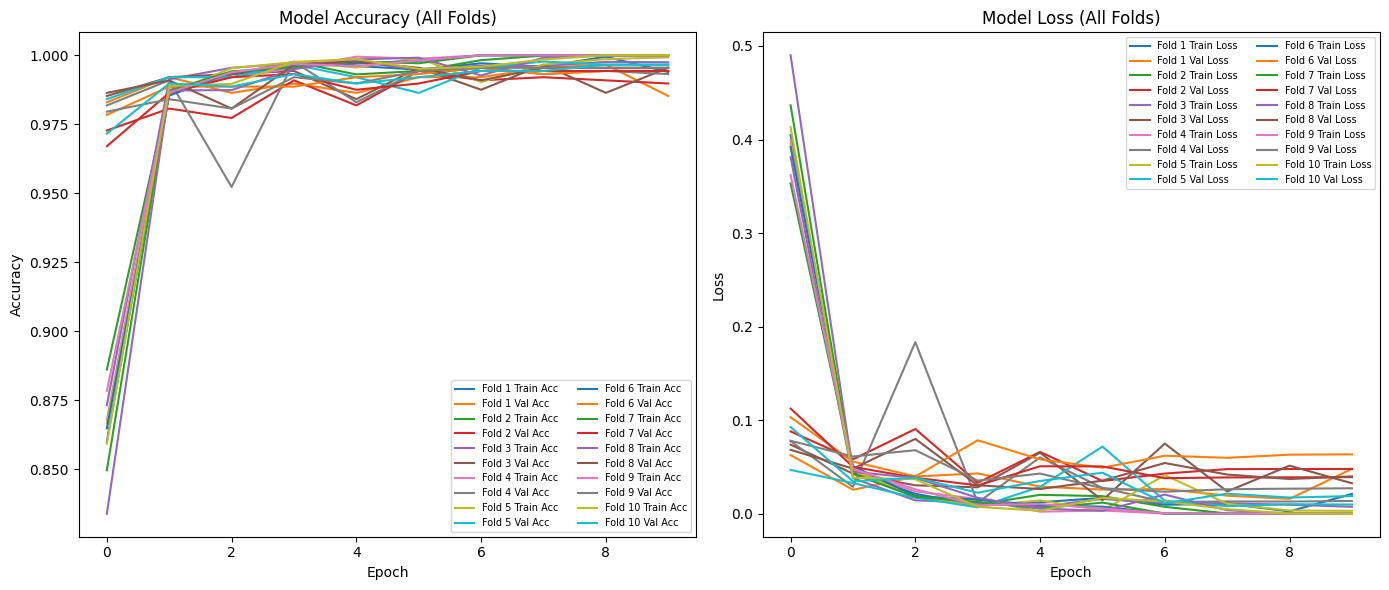


✅ K-Fold Summary Table:


,Fold,Precision %,Recall %,F1-score %,Training Time (ms),Train Loss,Val Loss,Train Accuracy %,Val Accuracy %,Specificity %,Cohen's Kappa %,ROC-AUC %
0,1,98.53,98.47,98.48,82227.69,0.03,0.05,99.13,98.52,99.79,98.31,100.00
1,2,98.99,99.06,99.02,81055.23,0.00,0.05,100.00,98.98,99.85,98.83,99.95
2,3,99.55,99.53,99.54,82141.20,0.00,0.03,100.00,99.55,99.94,99.48,99.98
3,4,99.31,99.28,99.29,81431.70,0.00,0.01,100.00,99.32,99.90,99.22,100.00
4,5,99.67,99.68,99.67,82005.53,0.00,0.01,100.00,99.66,99.95,99.61,100.00
5,6,99.44,99.43,99.44,81104.59,0.00,0.06,100.00,99.43,99.92,99.35,99.85
6,7,99.46,99.42,99.44,81364.30,0.00,0.04,100.00,99.43,99.92,99.35,99.99
7,8,99.51,99.51,99.51,80935.24,0.00,0.04,100.00,99.55,99.94,99.48,99.93
8,9,99.55,99.47,99.51,82106.95,0.00,0.03,100.00,99.55,99.93,99.48,99.99
9,10,99.68,99.72,99.70,81071.59,0.00,0.02,100.00,99.66,99.95,99.61,100.00



✅ Cross-validation results:
Accuracy: 99.36% (+/- 0.34)
Loss: 0.0341
Cohen's Kappa: 0.9927
Specificity: 0.9991
ROC-AUC: 0.9997


In [ ]:
#333333333###########333

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
from sklearn.model_selection import KFold
from sklearn.metrics import (
    cohen_kappa_score, confusion_matrix, roc_auc_score,
    precision_score, recall_score, f1_score, roc_curve, auc
)
from sklearn.preprocessing import label_binarize
import tensorflow as tf

# -----------------------
# Data
# -----------------------
X = np.load("/kaggle/working/X.npy")
y = np.load("/kaggle/working/y.npy")
num_classes = len(np.unique(y))

# -----------------------
# K-Fold Setup
# -----------------------
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

fold_no = 1
acc_per_fold, loss_per_fold, kappa_per_fold, specificity_per_fold, roc_auc_per_fold = [], [], [], [], []
histories = []  # store history for total curves
fold_metrics = []

for train_idx, val_idx in kfold.split(X, y):
    print(f"\n📌 Training Fold {fold_no} ...")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # -----------------------
    # Build & Compile Model
    # -----------------------
    model = build_hybrid_model()
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # -----------------------
    # Train Model
    # -----------------------
    start_time = time.time()
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10,
        batch_size=64,
        verbose=1
    )
    end_time = time.time()
    training_time_msec = (end_time - start_time) * 1000  # in milliseconds
    histories.append(history.history)

    # -----------------------
    # Evaluate
    # -----------------------
    train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)

    # Predictions
    y_val_probs = model.predict(X_val)
    y_val_pred = np.argmax(y_val_probs, axis=1)

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_val, y_val_pred, labels=np.unique(y))
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="viridis",
                xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.title(f"Confusion Matrix - Fold {fold_no}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig(f'confusion_matrix_fold{fold_no}.png', dpi=600)
    plt.close()

    # --- Accuracy & Loss Curves ---
    plt.figure(figsize=(10,4))
    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label="Train Acc")
    plt.plot(history.history['val_accuracy'], label="Val Acc")
    plt.title(f"Accuracy - Fold {fold_no}")
    plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.legend()
    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label="Train Loss")
    plt.plot(history.history['val_loss'], label="Val Loss")
    plt.title(f"Loss - Fold {fold_no}")
    plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.legend()
    plt.savefig(f'training_curves_fold{fold_no}.png', dpi=600)
    plt.close()

    # --- ROC & AUC Curves ---
    y_val_bin = label_binarize(y_val, classes=np.arange(num_classes))
    fpr, tpr, roc_auc = {}, {}, {}

    plt.figure(figsize=(8,6))
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_val_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2, label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

    # Macro average ROC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= num_classes
    roc_auc["macro"] = auc(all_fpr, mean_tpr)
    plt.plot(all_fpr, mean_tpr, color="navy", linestyle="--",
             label=f"Macro-average (AUC = {roc_auc['macro']:.2f})", lw=3)

    plt.plot([0,1],[0,1],'k--', lw=2)
    plt.xlim([0.0,1.0]); plt.ylim([0.0,1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - Fold {fold_no}")
    plt.legend(loc="lower right")
    plt.savefig(f'roc_curve_fold{fold_no}.png', dpi=300)
    plt.close()

    # --- Metrics ---
    roc_auc_score_macro = roc_auc_score(y_val_bin, y_val_probs, average="macro", multi_class="ovr")
    roc_auc_per_fold.append(roc_auc_score_macro)

    kappa = cohen_kappa_score(y_val, y_val_pred)

    specificity_list = []
    for i in range(num_classes):
        TP = cm[i,i]
        FP = cm[:,i].sum() - TP
        FN = cm[i,:].sum() - TP
        TN = cm.sum() - (TP + FP + FN)
        specificity_list.append(TN / (TN + FP + 1e-8))
    specificity = np.mean(specificity_list)

    precision = precision_score(y_val, y_val_pred, average='macro')
    recall = recall_score(y_val, y_val_pred, average='macro')
    f1 = f1_score(y_val, y_val_pred, average='macro')

    print(f"Fold {fold_no} - Acc: {val_acc:.4f}, Loss: {val_loss:.4f}, "
          f"Kappa: {kappa:.4f}, Specificity: {specificity:.4f}, "
          f"ROC-AUC: {roc_auc_score_macro:.4f}")

    # Store results
    acc_per_fold.append(val_acc * 100)
    loss_per_fold.append(val_loss)
    kappa_per_fold.append(kappa)
    specificity_per_fold.append(specificity)

    fold_metrics.append({
        "Fold": fold_no,
        "Precision %": precision*100,
        "Recall %": recall*100,
        "F1-score %": f1*100,
        "Training Time (ms)": training_time_msec,
        "Train Loss": train_loss,
        "Val Loss": val_loss,
        "Train Accuracy %": train_acc*100,
        "Val Accuracy %": val_acc*100,
        "Specificity %": specificity*100,
        "Cohen's Kappa %": kappa*100,
        "ROC-AUC %": roc_auc_score_macro*100
    })

    fold_no += 1

# -----------------------
# Total Accuracy & Loss Curves (All Folds)
# -----------------------
plt.figure(figsize=(14,6))
# Accuracy
plt.subplot(1,2,1)
for i, hist in enumerate(histories, 1):
    plt.plot(hist['accuracy'], label=f'Fold {i} Train Acc')
    plt.plot(hist['val_accuracy'], label=f'Fold {i} Val Acc')
plt.title("Model Accuracy (All Folds)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(fontsize=7, ncol=2)
plt.savefig('total_accuracy_curve.png', dpi=300)
# Loss
plt.subplot(1,2,2)
for i, hist in enumerate(histories, 1):
    plt.plot(hist['loss'], label=f'Fold {i} Train Loss')
    plt.plot(hist['val_loss'], label=f'Fold {i} Val Loss')
plt.title("Model Loss (All Folds)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize=7, ncol=2)
plt.tight_layout()
plt.savefig('total_loss_curve.png', dpi=300)
plt.show()

# -----------------------
# Final Summary
# -----------------------
metrics_df = pd.DataFrame(fold_metrics).round(2)
metrics_df.to_csv("kfold_summary_metrics.csv", index=False)
print("\n✅ K-Fold Summary Table:")
display(metrics_df)

print("\n✅ Cross-validation results:")
print(f"Accuracy: {np.mean(acc_per_fold):.2f}% (+/- {np.std(acc_per_fold):.2f})")
print(f"Loss: {np.mean(loss_per_fold):.4f}")
print(f"Cohen's Kappa: {np.mean(kappa_per_fold):.4f}")
print(f"Specificity: {np.mean(specificity_per_fold):.4f}")
print(f"ROC-AUC: {np.mean(roc_auc_per_fold):.4f}")


In [ ]:
# # --- Accuracy & Loss Together ---
# plt.figure(figsize=(10,4))

# # Accuracy subplot
# plt.subplot(1,2,1)
# for i, hist in enumerate(histories, 1):
#     plt.plot(hist['accuracy'], label=f'Fold {i} Train Acc')
#     plt.plot(hist['val_accuracy'], label=f'Fold {i} Val Acc')
# plt.title("Model Accuracy (All Folds)")
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")
# plt.legend(fontsize=7, ncol=2)

# # Loss subplot
# plt.subplot(1,2,2)
# for i, hist in enumerate(histories, 1):
#     plt.plot(hist['loss'], label=f'Fold {i} Train Loss')
#     plt.plot(hist['val_loss'], label=f'Fold {i} Val Loss')
# plt.title("Model Loss (All Folds)")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.legend(fontsize=7, ncol=2)

# plt.tight_layout()
# plt.savefig('accuracy_loss_curves.png', dpi=300)   # Save combined figure
# plt.show()


# # --- Accuracy Only ---
# plt.figure()
# for i, hist in enumerate(histories, 1):
#     plt.plot(hist['accuracy'], label=f'Fold {i} Train Acc')
#     plt.plot(hist['val_accuracy'], label=f'Fold {i} Val Acc')
# plt.title("Model Accuracy (All Folds)")
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")
# plt.legend(fontsize=7, ncol=2)
# plt.savefig('only_accuracy_curve.png', dpi=300)
# plt.show()


# # --- Loss Only ---
# plt.figure()
# for i, hist in enumerate(histories, 1):
#     plt.plot(hist['loss'], label=f'Fold {i} Train Loss')
#     plt.plot(hist['val_loss'], label=f'Fold {i} Val Loss')
# plt.title("Model Loss (All Folds)")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.legend(fontsize=7, ncol=2)
# plt.savefig('only_loss_curve.png', dpi=300)
# plt.show()


In [ ]:

# ------------------------
# Predict the probabilities
# ------------------------
y_prob = model.predict(X_val)  # Predicted probabilities for each class using the validation data

# ------------------------
# One-hot encode the true labels for multiclass
# ------------------------
from sklearn.preprocessing import label_binarize
y_val_bin = label_binarize(y_val, classes=[0, 1, 2, 3])  # One-hot encoding for multiclass

# ------------------------
# Calculate ROC and AUC for each class
# ------------------------
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, roc_auc = dict(), dict(), dict()
num_classes = len(np.unique(y_val))  # Adjust to the number of classes

# Compute ROC curve and AUC for each class
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_prob[:, i])
    roc_auc[i] = roc_auc_score(y_val_bin[:, i], y_prob[:, i])

# ------------------------
# Plot ROC Curves for each class
# ------------------------
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i+1} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve (ROC Curve)')
plt.legend(loc='lower right')
plt.savefig('ROC_curve.png', dpi=300)
plt.show()

# ------------------------
# Print AUC scores for each class
# ------------------------
for i in range(num_classes):
    print(f"Class {i+1} AUC: {roc_auc[i]:0.2f}")


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


IndexError: index 4 is out of bounds for axis 1 with size 4

In [ ]:
model.save("/kaggle/working/my_model.keras")


In [ ]:
model.save("/kaggle/working/my_model.h5")


In [ ]:
!pip install shap


In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


In [ ]:
# Save model in native Keras format
model.save("/kaggle/working/my_model.keras")


In [ ]:
import shap
import numpy as np

# Select a few background images (used for SHAP masking)
background = X_train[:50]  # small subset to save time


In [ ]:
# =========================================
# 1. Imports
# =========================================
import numpy as np
import matplotlib.pyplot as plt
import shap
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

# =========================================
# 2. Dataset split
# =========================================
# Assuming X, y already loaded (images & labels)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}")

# =========================================
# 3. Model Definition (Hybrid CNN + ViT + GRU)
# =========================================
input_shape = (160, 160, 3)
patch_size = 16
num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
projection_dim = 64
transformer_layers = 4
num_heads = 4
num_classes = 4

# ---- Patches Layer ----
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

# ---- Patch Encoder ----
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patches):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patches) + self.position_embedding(positions)
        return encoded

# ---- Build Hybrid Model ----
def build_hybrid_model():
    inputs = layers.Input(shape=input_shape)

    # CNN Branch
    x_cnn = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x_cnn = layers.MaxPooling2D((2,2))(x_cnn)
    x_cnn = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x_cnn)
    x_cnn = layers.MaxPooling2D((2,2))(x_cnn)
    x_cnn = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x_cnn)
    x_cnn = layers.MaxPooling2D((2,2))(x_cnn)
    x_cnn = layers.Flatten()(x_cnn)

    # ViT + GRU Branch
    x_vit = layers.Rescaling(1./255)(inputs)
    patches = Patches(patch_size)(x_vit)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.2
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        encoded_patches = layers.Add()([x3, x2])

    x_vit = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    x_vit = layers.Dropout(0.02)(x_vit)
    x_vit = layers.Flatten()(x_vit)
    x_vit = layers.Reshape((-1, x_vit.shape[-1]))(x_vit)
    x_vit = layers.GRU(256)(x_vit)

    # Concatenate CNN + ViT-GRU
    x = layers.concatenate([x_cnn, x_vit])
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.03)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

model = build_hybrid_model()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

# =========================================
# 4. Train Model (quick run)
# =========================================
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=3,   # change to 50+ for real training
    batch_size=32
)

# =========================================
# 5. SHAP Explanations
# =========================================
# Take background images
background = X_train[:50]

# Create SHAP masker
masker = shap.maskers.Image("inpaint_telea", X_train[0].shape)

# Build SHAP explainer
explainer = shap.Explainer(model, masker, output_names=[f"class_{i}" for i in range(num_classes)])

# Select test images
test_images = X_val[:5]

# Compute SHAP values
shap_values = explainer(test_images)

# =========================================
# 6. Visualization
# =========================================
# Show SHAP for predicted class of each image
preds = model.predict(test_images)
pred_classes = np.argmax(preds, axis=1)

for i, img in enumerate(test_images):
    class_idx = pred_classes[i]
    print(f"Image {i} predicted as class {class_idx}")
    shap.image_plot(shap_values.values[..., class_idx][i:i+1], img[np.newaxis])


In [ ]:
# Create SHAP image masker
masker = shap.maskers.Image("inpaint_telea", X_train[0].shape)

# Create explainer for your Keras model
explainer = shap.Explainer(model, masker, output_names=[str(i) for i in range(num_classes)])


In [ ]:
!pip install lime


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
import tensorflow as tf
from tensorflow.keras.models import load_model


In [ ]:
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras import layers
import tensorflow as tf

@register_keras_serializable()
class Patches(layers.Layer):
    def __init__(self, patch_size, **kwargs):  # accept **kwargs
        super(Patches, self).__init__(**kwargs)  # pass kwargs to Layer
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

    def get_config(self):
        config = super(Patches, self).get_config()
        config.update({"patch_size": self.patch_size})
        return config


@register_keras_serializable()
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super(PatchEncoder, self).__init__(**kwargs)
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patches):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patches) + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super(PatchEncoder, self).get_config()
        config.update({
            "num_patches": self.num_patches,
        })
        return config


In [ ]:
model.save("/kaggle/working/my_model_fixed.keras")


In [ ]:
from tensorflow.keras.models import load_model

model = load_model(
    "/kaggle/working/my_model_fixed.keras",
    custom_objects={"Patches": Patches, "PatchEncoder": PatchEncoder}
)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from tensorflow.keras.preprocessing import image
from lime import lime_image

# -----------------------------
# 1. Prediction function (same normalization used during training)
# -----------------------------
def predict_fn(images):
    images = images.astype('float32') / 255.0
    return model.predict(images)

# -----------------------------
# 2. Load single image
# -----------------------------
img_path = "/kaggle/input/brain-tumor-dataset-add/Brain tumor_Add/pituitary/Tr-pi_0022.jpg"
img = image.load_img(img_path, target_size=(160,160))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# -----------------------------
# 3. Run explainer
# -----------------------------
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    img_array[0].astype('double'),
    predict_fn,
    top_labels=4,
    hide_color=0,
    num_samples=1000
)

# -----------------------------
# 4. Model output
# -----------------------------
probs = predict_fn(img_array)[0]
predicted_class = np.argmax(probs)

print("Input Image Path:", img_path)
print("Predicted Class:", predicted_class)
print("Class Probabilities:", probs)

# -----------------------------
# 5. Top contributing features (with weights)
# -----------------------------
# explanation.local_exp is a dict: {class_label: [(superpixel_id, weight), ...]}
exp_weights = explanation.local_exp[predicted_class]

print("\nTop contributing features for class", predicted_class, ":")
for superpixel_id, weight in exp_weights[:10]:   # top 10
    print(f"Superpixel {superpixel_id}: {weight:.4f}")

# -----------------------------
# 6. Visualization
# -----------------------------
temp, mask = explanation.get_image_and_mask(
    label=predicted_class,
    positive_only=False,
    hide_rest=False,
    num_features=10,
    min_weight=0.0
)

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(img_array[0].astype('uint8'))

plt.subplot(1,2,2)
plt.title("LIME Explanation")
plt.imshow(mark_boundaries(temp.astype('uint8'), mask))

plt.show()


In [ ]:
def predict_fn(images):
    # Normalize images same as during training (ViT branch)
    images = images.astype('float32') / 255.0
    return model.predict(images)


In [ ]:
from tensorflow.keras.preprocessing import image


In [ ]:
# Example: load a single image from dataset
img_path = "/kaggle/input/brain-tumor-dataset-add/Brain tumor_Add/glioma/Tr-gl_0016.jpg"
img = image.load_img(img_path, target_size=(128,128))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)


In [ ]:
explainer = lime_image.LimeImageExplainer()


In [ ]:
explanation = explainer.explain_instance(
    img_array[0].astype('double'),  # single image
    predict_fn,                     # prediction function
    top_labels=4,                   # number of classes
    hide_color=0,
    num_samples=1000                # number of perturbed samples
)


In [ ]:
# Choose the class predicted by the model
predicted_class = np.argmax(model.predict(img_array))

# Get the image with explanation
temp, mask = explanation.get_image_and_mask(
    label=predicted_class,
    positive_only=False,
    hide_rest=False,
    num_features=10,
    min_weight=0.0
)

# Show the original and highlighted image
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(img_array[0].astype('uint8'))

plt.subplot(1,2,2)
plt.title("LIME Explanation")
plt.imshow(mark_boundaries(temp.astype('uint8'), mask))
plt.show()
